* filter dfSamples down to trial times
* z-score for plotting
* created some plots

## Required libraries

In [32]:
# for data
import pandas as pd
import numpy as np
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

# for interpolation
from scipy.interpolate import PchipInterpolator

# for parsing raw data
import sys
sys.path.insert(1, '/home/el736/f_mc1689_1/ArousalFC/docs/scripts/ParseEyeLinkAscFiles')
from ParseEyeLinkAsc import ParseEyeLinkAsc

# for plotting
import matplotlib.pyplot as plt

# for convolution with HRF
import scipy.stats
from scipy.stats import gamma

# for fMRI data
import nibabel as nb

# for z-scoring
import scipy.stats as stats

In [63]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

## Function definitions

In [64]:
# takes asc file of raw pupil data from HCP and parses into different dataframes
def parse_asc(asc_file):
    out_DFs = ParseEyeLinkAsc(asc_file)
    
    dfTrial = out_DFs[0]
    dfMsg = out_DFs[1]
    dfFix = out_DFs[2]
    dfSacc = out_DFs[3]
    dfBlink = out_DFs[4]
    dfSamples = out_DFs[5]
    
    return dfTrial, dfMsg, dfFix, dfSacc, dfBlink, dfSamples

In [65]:
# replaces blinks with NaNs
def pupil_nan(pupil_data):
    
    pupil_data['no_blink'] = pupil_data['LPupil']

    for i in range(0, dfBlink.shape[0]):

        start = dfBlink.expand_tStart[i]
        end = dfBlink.expand_tEnd[i]

        pupil_data.loc[((pupil_data.tSample >= start) & (pupil_data.tSample <= end)), 'no_blink'] = np.nan
        
    return pupil_data

In [66]:
# interpolates blinks
def interpolate_pupil(pupil_data):
    pupil_data[0] = np.nanmean(pupil_data)
    #pupil_data[-1] = np.nanmean(pupil_data)
    f = PchipInterpolator(np.where(~np.isnan(pupil_data))[0],
                          pupil_data[~np.isnan(pupil_data)])
    nan_pupil_data = f(np.arange(len(pupil_data)))
    return nan_pupil_data

In [67]:
# convolve with hrf
def convolve_with_hrf(pupil_data, srate, TR_duration):
    hrf = glm.first_level.spm_hrf(TR_duration / 1000, srate)
    hrf_pupil = np.convolve(pupil_data, hrf)[:len(pupil_data)]
    return hrf_pupil

## Get pupil data

In [68]:
# parse raw pupil data
work_file = '/home/el736/f_mc1689_1/ExternalDatasets/HCP/100610/unprocessed/7T/rfMRI_REST1_PA/LINKED_DATA/EYETRACKER/100610_7T_REST1_eyetrack.asc'
dfTrial, dfMsg, dfFix, dfSacc, dfBlink, dfSamples = parse_asc(work_file)

Reading in EyeLink file /home/el736/f_mc1689_1/ExternalDatasets/HCP/100610/unprocessed/7T/rfMRI_REST1_PA/LINKED_DATA/EYETRACKER/100610_7T_REST1_eyetrack.asc...
Done! Took 0.458907 seconds.
Sorting lines...
Done! Took 4.104345 seconds.
Parsing recording markers...
1 recording periods found.
Parsing stimulus messages...
Done! Took 0.002630 seconds.
Parsing fixations...
Done! Took 0.296364 seconds.
Parsing saccades...
Done! Took 0.299574 seconds.
Parsing blinks...
Done! Took 0.600528 seconds.
monocular data detected (L eye).
Parsing samples...
Done! Took 1.1 seconds.


## Data Exploration

In [69]:
dfTrial.head()

,tStart,tEnd,xRes,yRes
0,10570873,11567709,44.53,44.55


In [70]:
dfMsg.head()

,time,text
0,10554831,DISPLAY_COORDS 0 0 1024 768
1,10568501,!CAL
2,10568502,!CAL Calibration points:
3,10568502,"!CAL 21.3, -26.4 0, 0"
4,10568502,"!CAL 18.1, -34.2 0, -1128"


In [71]:
dfMsg.tail()

,time,text
924,11562594,TRIALID 896
925,11563594,TRIALID 897
926,11564594,TRIALID 898
927,11565594,TRIALID 899
928,11566594,TRIALID 900


In [72]:
dfFix.head()

,eye,tStart,tEnd,duration,xAvg,yAvg,pupilAvg
0,L,10570880,10571398,519,542.2,377.7,1720
1,L,10571423,10571569,147,476.2,318.9,1396
2,L,10571610,10571730,121,305.9,293.8,959
3,L,10571949,10572007,59,648.7,339.4,712
4,L,10572041,10572247,207,775.4,347.6,670


In [73]:
# quantitity and duration of blinks
dfBlink.head()

,eye,tStart,tEnd,duration
0,L,10571779,10571906,128
1,L,10573631,10573726,96
2,L,10573829,10574029,201
3,L,10576181,10576284,104
4,L,10576307,10576312,6


In [74]:
dfSamples.head()

,tSample,LX,LY,LPupil,RX,RY,RPupil
0,10570873,550.2,371.3,1550.0,NaN,NaN,NaN
1,10570874,550.2,371.2,1550.0,NaN,NaN,NaN
2,10570875,550.5,370.2,1551.0,NaN,NaN,NaN
3,10570876,550.7,369.5,1551.0,NaN,NaN,NaN
4,10570877,550.8,368.8,1552.0,NaN,NaN,NaN


## Data Pre-processing

## remove blinks and interpolate pupil data

In [75]:
pd.options.display.max_columns = None

In [76]:
# load eye daya summary
eye_data_summary = pd.read_csv('/projects/f_mc1689_1/ArousalFC/data/results/group/eye_data_summary_csv')
display(eye_data_summary.loc[eye_data_summary['subject']==100610, ])

,Unnamed: 0,subject,session,ET_duration_min,percent_miss_R,percent_miss_L,scan,block,failsafe,startline,endline,numlines,srate,durexpected,duration,durfrac,eyefrac,TRcount,TRonset,TRduration,TRfrac
0,0,100610,rfMRI_REST4_AP,16.510117,100.0,3.808675,REST4,1,0,55,997517,997463,1000,900,990.607,110.067,96.191,900,90.518,900.089,100.009
1,0,100610,rfMRI_REST1_PA,16.613933,100.0,5.249610,REST1,1,0,55,1005562,1005508,1000,900,996.836,110.759,94.750,900,96.745,900.091,100.010
2,0,100610,rfMRI_REST3_PA,16.527350,100.0,1.775643,REST3,1,0,86,999026,998941,1000,900,991.641,110.182,98.224,900,91.548,900.093,100.010
3,0,100610,rfMRI_REST2_AP,16.482283,100.0,12.464292,REST2,1,0,55,997885,997831,1000,900,988.937,109.881,87.535,900,88.844,900.093,100.010


In [77]:
# offset onset and end of blinks by 70 ms
offset = np.array([70]*dfBlink.shape[0]).T

dfBlink['expand_tStart'] = dfBlink['tStart']-offset
dfBlink['expand_tEnd'] = dfBlink['tEnd']+offset

dfBlink.head()

,eye,tStart,tEnd,duration,expand_tStart,expand_tEnd
0,L,10571779,10571906,128,10571709,10571976
1,L,10573631,10573726,96,10573561,10573796
2,L,10573829,10574029,201,10573759,10574099
3,L,10576181,10576284,104,10576111,10576354
4,L,10576307,10576312,6,10576237,10576382


In [78]:
# replace blinks with nan
dfSamples = pupil_nan(dfSamples)

# interpolate
blink_interpol = dfSamples['no_blink']
dfSamples['blink_interpol'] = interpolate_pupil(blink_interpol)


/tmp/ipykernel_25671/800877945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_data[0] = np.nanmean(pupil_data)


In [79]:
dfSamples.head()

,tSample,LX,LY,LPupil,RX,RY,RPupil,no_blink,blink_interpol
0,10570873,550.2,371.3,1550.0,NaN,NaN,NaN,814.767346,814.767346
1,10570874,550.2,371.2,1550.0,NaN,NaN,NaN,1550.000000,1550.000000
2,10570875,550.5,370.2,1551.0,NaN,NaN,NaN,1551.000000,1551.000000
3,10570876,550.7,369.5,1551.0,NaN,NaN,NaN,1551.000000,1551.000000
4,10570877,550.8,368.8,1552.0,NaN,NaN,NaN,1552.000000,1552.000000


In [80]:
# add end time for each trial to dfMsg

dfMsg['end_time'] = dfMsg['time'].shift(-1)
dfMsg['end_time'].iloc[-1] = dfMsg['end_time'].iloc[-2] + 1000
dfMsg.iloc[25:35]

/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time,text,end_time
25,10570864,THRESHOLDS L 137 251,10570864.0
26,10570864,ELCL_PROC ELLIPSE (5),10570864.0
27,10570864,ELCL_EFIT_PARAMS 1.01 4.00 0.15 0.05 0.65 0.65...,10570865.0
28,10570865,!MODE RECORD CR 1000 2 1 L,10667618.0
29,10667618,TRIALID 1,10668552.0
30,10668552,TRIALID 2,10669552.0
31,10669552,TRIALID 3,10670552.0
32,10670552,TRIALID 4,10671552.0
33,10671552,TRIALID 5,10672552.0
34,10672552,TRIALID 6,10673552.0


In [81]:
# get start and end time of trials to filter dfSamples
start_idx = dfMsg[dfMsg['text']=='TRIALID 1'].index.values.astype(int)[0]
start_time = dfMsg['time'].iloc[start_idx]

end_idx = dfMsg[dfMsg['text']=='TRIALID 900'].index.values.astype(int)[0]
end_time = dfMsg['end_time'].iloc[end_idx]

In [82]:
start_time

10667618

In [83]:
dfSamples = dfSamples.loc[(dfSamples['tSample']>=start_time) & (dfSamples['tSample']<=end_time)]

In [84]:
dfSamples.tail()

,tSample,LX,LY,LPupil,RX,RY,RPupil,no_blink,blink_interpol
996717,11567590,559.1,421.3,710.0,NaN,NaN,NaN,710.0,710.0
996718,11567591,560.7,421.3,710.0,NaN,NaN,NaN,710.0,710.0
996719,11567592,562.6,421.3,709.0,NaN,NaN,NaN,709.0,709.0
996720,11567593,562.9,421.1,709.0,NaN,NaN,NaN,709.0,709.0
996721,11567594,563.0,421.2,709.0,NaN,NaN,NaN,709.0,709.0


In [85]:
len(dfSamples['tSample'])

899977

In [86]:
# convert trial interval starting from 0
start_time = 0
end_time = len(dfSamples['tSample'])
dfSamples['time'] = range(start_time, end_time)

In [87]:
dfSamples.tail()

,tSample,LX,LY,LPupil,RX,RY,RPupil,no_blink,blink_interpol,time
996717,11567590,559.1,421.3,710.0,NaN,NaN,NaN,710.0,710.0,899972
996718,11567591,560.7,421.3,710.0,NaN,NaN,NaN,710.0,710.0,899973
996719,11567592,562.6,421.3,709.0,NaN,NaN,NaN,709.0,709.0,899974
996720,11567593,562.9,421.1,709.0,NaN,NaN,NaN,709.0,709.0,899975
996721,11567594,563.0,421.2,709.0,NaN,NaN,NaN,709.0,709.0,899976


In [88]:
# z-score for plotting
z_pupil = stats.zscore(dfSamples['blink_interpol'])
z_raw = stats.zscore(dfSamples['LPupil'])

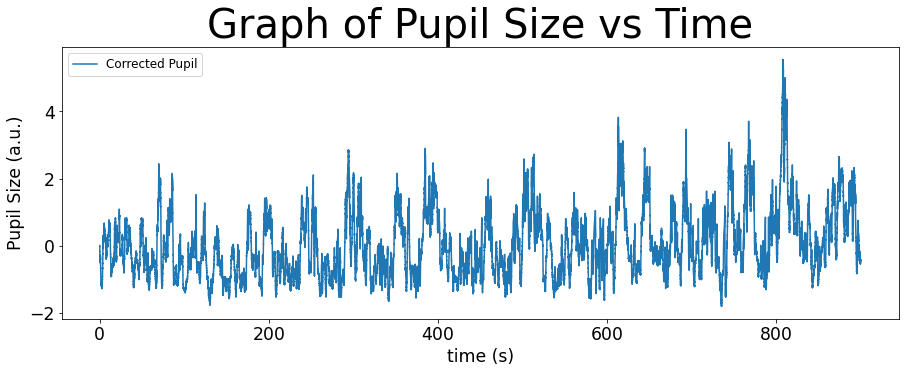

In [89]:
# plot of pupil size over samples, raw and blinks removed with interpolation

# set figure size
plt.figure(figsize=(15, 5))

# fig.suptitle('test title', fontsize=20)
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# fig.savefig('test.jpg')

# plot interpolated pupil data, blinks removed
plt.plot(dfSamples['time']/1000, z_pupil)
#plt.plot(dfSamples['time']/1000, dfSamples['blink_interpol'])

plt.xlabel('time (s)')
plt.ylabel('Pupil Size (a.u.)')
plt.title('Graph of Pupil Size vs Time', fontsize=40)
plt.legend(['Corrected Pupil'], loc='upper left', fontsize=12)
plt.show()

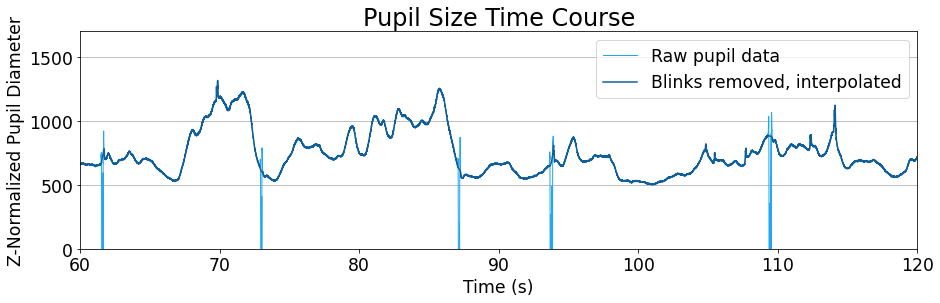

In [90]:
# plot of average pupil size over samples, raw and blinks removed with interpolation, time changed to seconds

# set figure size
plt.figure(figsize=(15, 4))

time_ch = dfSamples['time']/1000

# plot raw data and data without blinks
# plt.plot(time_ch, z_raw, color='#22a7f0', linewidth=0.5)
# plt.plot(time_ch, z_pupil, color='#115f9a')
plt.plot(time_ch, dfSamples['LPupil'], color='#22a7f0', linewidth=1.0)
plt.plot(time_ch, dfSamples['blink_interpol'], color='#115f9a')

# get start and end times to plot a 60-second interval
start_time = 60
end_time = 120

plt.xlim(start_time, end_time)
plt.ylim(0, 1700)
plt.xlabel('Time (s)')
plt.ylabel('Z-Normalized Pupil Diameter')
plt.grid(axis = 'y')
#plt.xticks(np.arange(0, 1000, 100))
plt.title('Pupil Size Time Course', fontsize=24)
plt.legend(['Raw pupil data', 'Blinks removed, interpolated'])
plt.show()

## Convolve with HRF

In [91]:
# canonical HRF
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

Text(0, 0.5, 'Signal Strength')

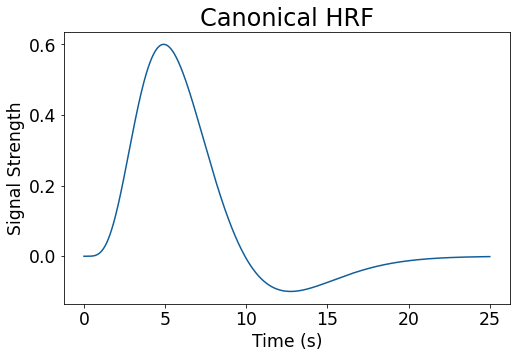

In [92]:
# HRF resolution to TR
# HRF lasting 25 s.
plt.figure(figsize=(8, 5))
TR = 0.001
tr_times = np.arange(0, 25, TR)
hrf_at_trs = hrf(tr_times)

plt.plot(tr_times, hrf_at_trs, color='#115f9a')
plt.title('Canonical HRF', fontsize=24)
plt.xlabel('Time (s)')
plt.ylabel('Signal Strength')
#plt.ylabel('HRF sampled every 0.001 second')

In [93]:
dfSamples.reset_index(drop=True, inplace=True)

In [94]:
dfSamples.head()

,tSample,LX,LY,LPupil,RX,RY,RPupil,no_blink,blink_interpol,time
0,10667618,581.2,326.1,796.0,NaN,NaN,NaN,796.0,796.0,0
1,10667619,580.7,326.5,796.0,NaN,NaN,NaN,796.0,796.0,1
2,10667620,580.4,326.3,796.0,NaN,NaN,NaN,796.0,796.0,2
3,10667621,580.1,326.0,797.0,NaN,NaN,NaN,797.0,797.0,3
4,10667622,579.9,326.2,798.0,NaN,NaN,NaN,798.0,798.0,4


In [95]:
# convolve pupil data with HRF
convolved = np.convolve(dfSamples['blink_interpol'], hrf_at_trs)

In [96]:
# remove last convolved item to match dimensions and add to dfSamples
n_to_remove = len(hrf_at_trs) - 1
convolved = convolved[:-n_to_remove]
dfSamples['convolved'] = convolved
dfSamples['convolved'].iloc[0] = np.nanmean(dfSamples['convolved'])
dfSamples['convolved'].iloc[-1] = np.nanmean(dfSamples['convolved'])

/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Downsample to TR

In [97]:
# average over Trials

In [98]:
# calculate average pupil size over each trial (with blinks)

convolved_downsample = []

start_idx = dfMsg[dfMsg['text']=='TRIALID 1'].index.values.astype(int)[0]
end_idx = dfMsg[dfMsg['text']=='TRIALID 900'].index.values.astype(int)[0] + 1
#end_idx = dfMsg.shape[0]

for i in range(start_idx, end_idx):
    start_time = dfMsg.iloc[i]['time']
    end_time = dfMsg.iloc[i]['end_time']

    convolved_downsample.append(dfSamples[(dfSamples['tSample'] > start_time) & (dfSamples['tSample'] < end_time)]['convolved'].mean()) 

ds_list = {'convolved_downsample': convolved_downsample}     
df_down_sample = pd.DataFrame(ds_list)

# convert trial interval starting from 0
start_time = 0
end_time = df_down_sample.shape[0]
df_down_sample['time'] = range(start_time, end_time)

df_down_sample.head()

,convolved_downsample,time
0,173.282865,0
1,12355.895835,1
2,100352.499511,2
3,323851.220643,3
4,650089.072861,4


In [99]:
dfSamples.head()

,tSample,LX,LY,LPupil,RX,RY,RPupil,no_blink,blink_interpol,time,convolved
0,10667618,581.2,326.1,796.0,NaN,NaN,NaN,796.0,796.0,0,1.803232e+06
1,10667619,580.7,326.5,796.0,NaN,NaN,NaN,796.0,796.0,1,2.301754e-14
2,10667620,580.4,326.3,796.0,NaN,NaN,NaN,796.0,796.0,2,7.588426e-13
3,10667621,580.1,326.0,797.0,NaN,NaN,NaN,797.0,797.0,3,6.340929e-12
4,10667622,579.9,326.2,798.0,NaN,NaN,NaN,798.0,798.0,4,2.984031e-11


In [100]:
len(dfSamples['convolved'])

899977

In [101]:
len(df_down_sample['convolved_downsample'])

900

In [102]:
# z-score for plotting

z_convol = stats.zscore(df_down_sample['convolved_downsample'])
z_convol_raw = stats.zscore(dfSamples['convolved'])



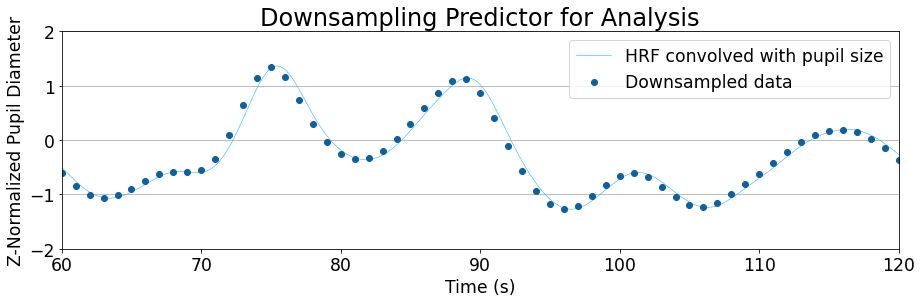

In [103]:
# plot of HRF convolved predictor (convolved with pupil data), before and after downsampling

# set figure size
plt.figure(figsize=(15, 4))

time_ch = dfSamples['time']/1000

# plot data without blinks
plt.plot(time_ch, z_convol_raw, color='#22a7f0', linewidth=0.5)
plt.plot(df_down_sample['time'], z_convol, color='#115f9a', marker='o', linestyle="None")

# get start and end times to plot a 60-second interval
start_time = 60
end_time = 120

plt.xlim(start_time, end_time)
plt.ylim(-2, 2)
plt.xlabel('Time (s)')
plt.ylabel('Z-Normalized Pupil Diameter')
plt.grid(axis = 'y')
plt.title('Graph of HRF Convolved Predictor vs Time')
#plt.xticks(np.arange(0, 1000, 100))
plt.title('Downsampling Predictor for Analysis', fontsize=24)
plt.legend(['HRF convolved with pupil size','Downsampled data'])
plt.show()

## Get global signal data

In [104]:
df_fmri_raw = nb.load('/home/el736/f_mc1689_1/ExternalDatasets/HCP/100610/MNINonLinear/Results/rfMRI_REST1_7T_PA/rfMRI_REST1_7T_PA_Atlas_MSMAll_hp2000_clean.dtseries.nii')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [105]:
brain_data = nb.load('/home/el736/f_mc1689_1/ExternalDatasets/HCP/100610/MNINonLinear/Results/rfMRI_REST1_7T_PA/rfMRI_REST1_7T_PA_Atlas_MSMAll_hp2000_clean.dtseries.nii').get_fdata(dtype=np.float32) 
global_signal = brain_data.mean(axis=-1)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [106]:
global_signal.size

900

In [107]:
df_down_sample['time'].shape

(900,)

## plots

In [108]:
# z-score for plotting

z_convol = stats.zscore(df_down_sample['convolved_downsample'])

z_global = stats.zscore(global_signal)

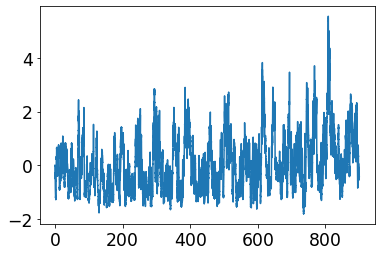

In [122]:
plt.plot(time_ch, z_pupil)

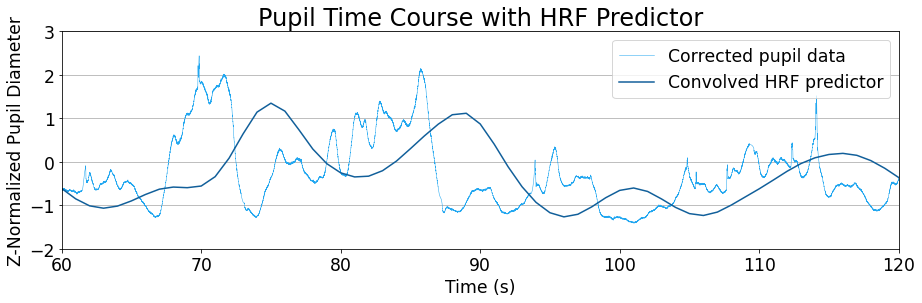

In [109]:
# plot of HRF convolved predictor (convolved with pupil data), before and after downsampling

# set figure size
plt.figure(figsize=(15, 4))

time_ch = dfSamples['time']/1000

# plot data without blinks
#plt.plot(time_ch, z_raw, color='#22a7f0', linewidth=0.5)
plt.plot(time_ch, z_pupil, color='#22a7f0', linewidth=0.5)
plt.plot(df_down_sample['time'], z_convol, color='#115f9a')

# get start and end times to plot a 60-second interval
start_time = 60
end_time = 120

plt.xlim(start_time, end_time)
plt.ylim(-2, 3)
plt.xlabel('Time (s)')
plt.ylabel('Z-Normalized Pupil Diameter')
plt.grid(axis = 'y')
plt.title('Pupil Time Course with HRF Predictor', fontsize=24)
plt.legend(['Corrected pupil data','Convolved HRF predictor'])
plt.show()

## calculate correlation

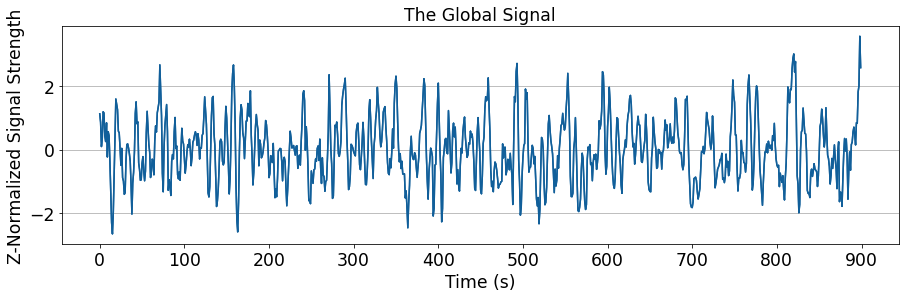

In [110]:
# plot of global BOLD signal

# set figure size
plt.figure(figsize=(15, 4))

# plot raw data and data without blinks
plt.plot(z_global, color='#115f9a')
plt.plot(z_global, color='#115f9a')

plt.xlabel('Time (s)')
plt.ylabel('Z-Normalized Signal Strength')
plt.grid(axis = 'y')
plt.xticks(np.arange(0, 1000, 100))
plt.title('The Global Signal')
#plt.legend([''])
plt.show()


In [111]:
# get convolved signal
convolved_signal = df_down_sample['convolved_downsample']

In [112]:
# create dataframe of pridictor, global signal, and time

ds_list = {'global_signal': global_signal, 'convolved_signal': convolved_signal}     
df_corr = pd.DataFrame(ds_list)

# convert trial interval starting from 0
start_time = 0
end_time = len(global_signal)
df_corr['time'] = range(start_time, end_time)

df_corr

,global_signal,convolved_signal,time
0,11002.208984,1.732829e+02,0
1,10996.798828,1.235590e+04,1
2,10981.170898,1.003525e+05,2
3,10986.473633,3.238512e+05,3
4,11003.541992,6.500891e+05,4
...,...,...,...
895,10996.225586,2.493823e+06,895
896,11016.228516,2.497070e+06,896
897,11020.183594,2.412480e+06,897
898,11052.060547,2.241421e+06,898


(60.0, 120.0)

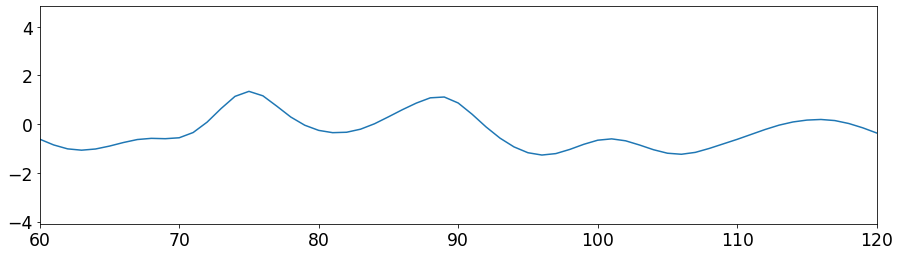

In [126]:
# set figure size
plt.figure(figsize=(15, 4))
plt.plot(df_corr['time'], z_convol)
plt.xlim(60, 120)

(60.0, 120.0)

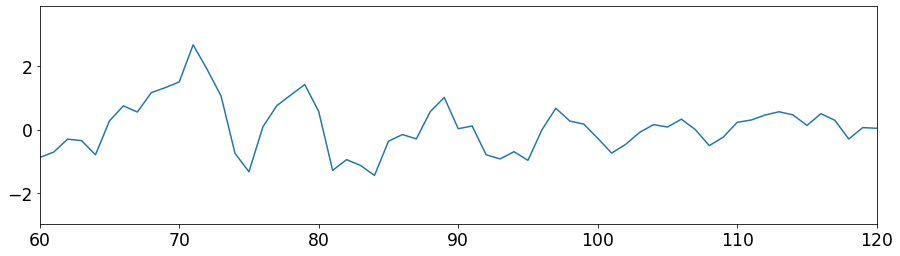

In [127]:
# set figure size
plt.figure(figsize=(15, 4))
plt.plot(df_corr['time'], z_global)
plt.xlim(60, 120)

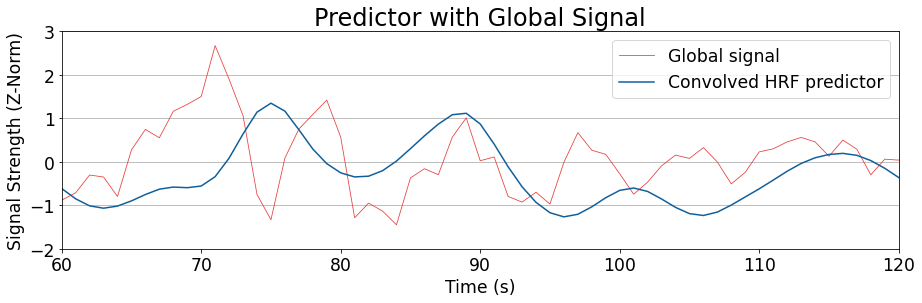

In [113]:
# plot of average pupil size over samples, raw and blinks removed with interpolation, time changed to seconds

# set figure size
plt.figure(figsize=(15, 4))

# plot raw data and data without blinks
plt.plot(df_corr['time'], z_global, color='#E64241', linewidth=0.8)
plt.plot(df_corr['time'], z_convol, color='#115f9a')

# get start and end times to plot a 60-second interval
start_time = 60
end_time = 120

plt.xlim(start_time, end_time)
plt.ylim(-2, 3)
plt.xlabel('Time (s)')
plt.grid(axis = 'y')
plt.ylabel('Signal Strength (Z-Norm)')
plt.title('Predictor with Global Signal', fontsize=24)
plt.legend(['Global signal', 'Convolved HRF predictor'])
plt.show()

/tmp/ipykernel_25671/3776190277.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, m*x+b, '--k', color='#22a7f0', linewidth=1.5)


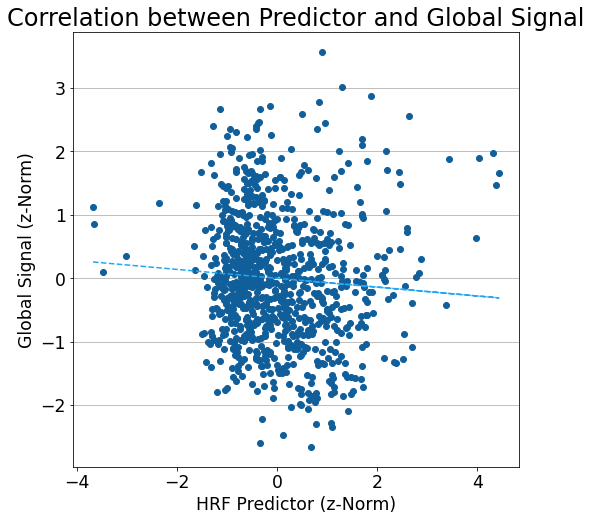

In [114]:
# scatterplot of global signal and predictor

# set figure size
plt.figure(figsize=(8, 8))

x = z_convol
y = z_global

# x = df_corr['convolved_signal']
# y = df_corr['global_signal']

m, b = np.polyfit(x, y, 1)

# plt.plot(x, x, color='#22a7f0', linewidth=1.0)
# plt.plot(df_corr['convolved_signal'], df_corr['global_signal'], color='#115f9a', marker='o', linestyle="None")

plt.plot(z_convol, z_global, color='#115f9a', marker='o', linestyle="None")
plt.plot(x, m*x+b, '--k', color='#22a7f0', linewidth=1.5)
plt.title('Correlation between Predictor and Global Signal', fontsize=24)

plt.xlabel('HRF Predictor (z-Norm)')
plt.ylabel('Global Signal (z-Norm)')
plt.grid(axis = 'y')

plt.show()

In [115]:
m

-0.06979768460460699

In [116]:
from scipy.stats import pearsonr

In [117]:
corr, p = pearsonr(convolved_signal, global_signal)
print('Pearsons correlation: %.3f' % corr, 'with p-value: %.3f' % p)

Pearsons correlation: -0.070 with p-value: 0.036


In [118]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

(array([  4.,   1.,  29., 326., 262., 169.,  73.,  27.,   4.,   5.]),
 array([    173.28,  397456.97,  794740.65, 1192024.33, 1589308.01,
        1986591.7 , 2383875.38, 2781159.06, 3178442.74, 3575726.43,
        3973010.11]),
 <BarContainer object of 10 artists>)

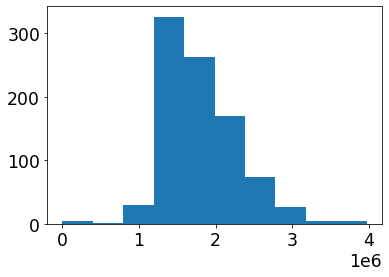

In [119]:
plt.hist(convolved_signal)

(array([  9.,  51., 137., 199., 235., 142.,  79.,  31.,  15.,   2.]),
 array([10925.03, 10937.74, 10950.44, 10963.14, 10975.84, 10988.55,
        11001.25, 11013.95, 11026.66, 11039.36, 11052.06], dtype=float32),
 <BarContainer object of 10 artists>)

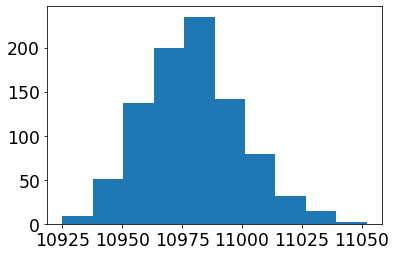

In [120]:
plt.hist(global_signal)

/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


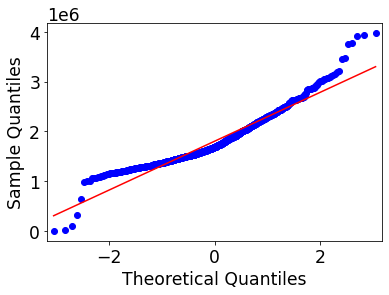

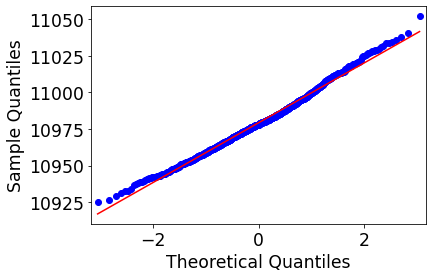

In [121]:
qqplot(convolved_signal, line='s')
qqplot(global_signal, line='s')
plt.show()